<a href="https://www.kaggle.com/code/dcgann/histopathologic-cancer-detection-using-attention?scriptVersionId=184206759" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [4]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from torchvision.models import resnet18, ResNet18_Weights
import torchvision.models as models
from PIL import Image
import pandas as pd
import cv2
import numpy as np

In [5]:
from torchvision.transforms import ToTensor
import rasterio
from rasterio.plot import show
import numpy as np

path="/kaggle/input/hcd-cropped/test/00006537328c33e284c973d7b39d340809f7271b.tif"
with rasterio.open(path) as image:
    image_array = image.read()

torch_image = ToTensor()(image_array)
print(torch_image.shape)

torch.Size([32, 3, 32])


/opt/conda/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


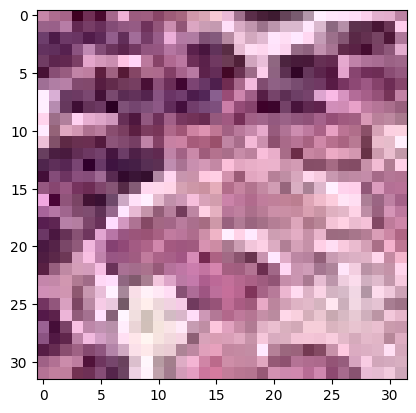

<Axes: >

In [6]:
rasterio.open(path).read()
show(image_array)

In [11]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

image_dir = '/kaggle/input/hcd-cropped/train'
labels_csv = '/kaggle/input/hcd-cropped/train_labels.csv'

# Load the labels into a DataFrame
labels_df = pd.read_csv(labels_csv)

# Define the custom dataset
class CancerDataset(Dataset):
    def __init__(self, image_dir, labels_df, transform=None):
        self.image_dir = image_dir
        self.labels_df = labels_df
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        # Get the image file name and label
        img_name = self.labels_df.iloc[idx, 0]
        label = self.labels_df.iloc[idx, 1]

        # Load the image
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path+'.tif')

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),          
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Create the dataset
cancer_dataset = CancerDataset(image_dir=image_dir, labels_df=labels_df, transform=transform)

In [12]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(cancer_dataset, [0.8, 0.1, 0.1])
#print(train_size, test_size, val_size)
train_loader=DataLoader(train_dataset, batch_size=32, shuffle=True )
val_loader=DataLoader(val_dataset, batch_size=32, shuffle=True )
test_loader =DataLoader(test_dataset, batch_size=32, shuffle=True )


In [9]:
len(cancer_dataset)


220025

In [ ]:
class AttentionModule(nn.Module):
    def __init__(self):
        super(AttentionModule, self).__init__()
        original_model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.features = nn.Sequential(*list(original_model.children())[:-1])  # Keep the AdaptiveAvgPool2d
        self.fc1 = nn.Linear(512, 16)
        self.dropout = nn.Dropout(0.5)
        self.attention = nn.Sequential(
            nn.Linear(16, 16),
            nn.Tanh(),
            nn.Linear(16, 1),
            nn.Softmax(dim=1)  # Softmax over features within a batch
        )
        self.classifier = nn.Linear(16, 2)

    def forward(self, x, return_attention=False):
        f = self.features(x)
        f = torch.flatten(f, 1)
        f = self.dropout(f)
        f = self.fc1(f)
        a = self.attention(f)
        g = torch.bmm(a.unsqueeze(2).transpose(1, 2), f.unsqueeze(1)).squeeze(1)
        y = self.classifier(f)
        if return_attention:
            return y, a  # Return output and attention weights to visualize attention map
        return y


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AttentionModule().to(device)


In [22]:
from torchinfo import summary
summary(model, input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
AttentionModule                               [32, 2]                   --
├─Sequential: 1-1                             [32, 512, 1, 1]           --
│    └─Conv2d: 2-1                            [32, 64, 112, 112]        9,408
│    └─BatchNorm2d: 2-2                       [32, 64, 112, 112]        128
│    └─ReLU: 2-3                              [32, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                         [32, 64, 56, 56]          --
│    └─Sequential: 2-5                        [32, 64, 56, 56]          --
│    │    └─BasicBlock: 3-1                   [32, 64, 56, 56]          73,984
│    │    └─BasicBlock: 3-2                   [32, 64, 56, 56]          73,984
│    └─Sequential: 2-6                        [32, 128, 28, 28]         --
│    │    └─BasicBlock: 3-3                   [32, 128, 28, 28]         230,144
│    │    └─BasicBlock: 3-4                   [32, 128, 28, 28]         295,42

In [13]:
def train_model(model, train_loader, device, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def validate_model(model, val_loader, device, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(val_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AttentionModule().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 6
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_model(model, train_loader, device, optimizer, criterion)
    val_loss, val_accuracy = validate_model(model, val_loader, device, criterion)
    print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

Epoch 1: Train Loss: 0.4271, Train Accuracy: 81.03%, Validation Loss: 0.4236, Validation Accuracy: 81.07%
Epoch 2: Train Loss: 0.3761, Train Accuracy: 83.84%, Validation Loss: 0.3545, Validation Accuracy: 84.75%
Epoch 3: Train Loss: 0.3456, Train Accuracy: 85.43%, Validation Loss: 0.3393, Validation Accuracy: 85.24%
Epoch 4: Train Loss: 0.3235, Train Accuracy: 86.48%, Validation Loss: 0.3150, Validation Accuracy: 86.45%
Epoch 5: Train Loss: 0.3051, Train Accuracy: 87.35%, Validation Loss: 0.3158, Validation Accuracy: 86.66%
Epoch 6: Train Loss: 0.2866, Train Accuracy: 88.21%, Validation Loss: 0.3242, Validation Accuracy: 86.25%


In [14]:
torch.save(model.state_dict(), '6-epoch-cancer_detection_weights.pth')


In [15]:
test_loss, test_accuracy = validate_model(model, test_loader, device, criterion)
print(f'test Loss: {test_loss:.4f}, test Accuracy: {test_accuracy:.2f}')

test Loss: 0.3130, test Accuracy: 86.71
